# Testing CircuitQ

In [1]:
import circuitq as cq

import numpy as np
import networkx as nx
import scqubits as sc
import matplotlib.pyplot as plt

## Test 0: LC-Circuit
#### Circuit

In [2]:
graph = nx.MultiGraph()
graph.add_edge(0,1, element = 'C')
graph.add_edge(0,1, element = 'L');

#### Symbolic Hamiltonian

In [3]:
circuit = cq.CircuitQ(graph)
circuit.h

\Phi_{1}**2/(2*L_{010}) + 0.5*q_{1}**2/C_{01}

#### Diagonalization

In [4]:
h_num = circuit.get_numerical_hamiltonian(400)
eigv, eigs = circuit.get_eigensystem()

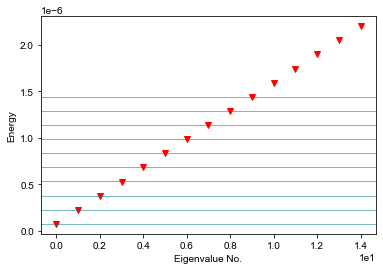

In [5]:
plt.figure(figsize=(6,4))
plt.plot(np.arange(15), eigv[:15], 'rv')
for n in range(10):
    plt.axhline(eigv[0]+n*circuit.c_v["hbar"]*circuit.c_v["omega"], lw=0.5)
plt.xlabel("Eigenvalue No.")
plt.ylabel("Energy")
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.show() 

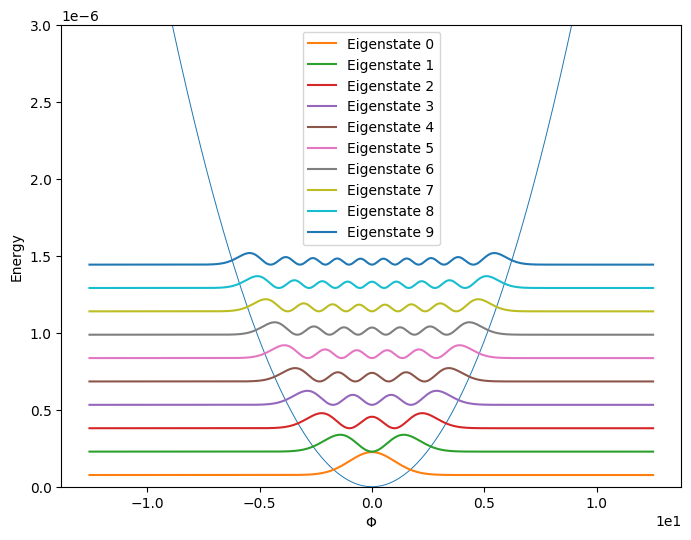

In [6]:
plt.style.use('default')
plt.figure(figsize=(8,6))
def potential(phi):
    return phi**2/(2*circuit.c_v["L"])
plt.plot(circuit.coord_list, potential(circuit.coord_list), lw=0.7)
for n in range(10):
    plt.plot(circuit.coord_list, 
            eigv[n]+(abs(eigs[:,n])**2*(max(circuit.coord_list)**2/(2*circuit.c_v["L"]))),
            label="Eigenstate " +str(n))
# plt.xlim(-10,10)
plt.ylim(0,3e-6)
plt.xlabel(r"$\Phi$")
plt.ylabel("Energy")
plt.legend()
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.show()

## Test 1: Transmon
### CircuitQ
#### Circuit

In [7]:
graph = nx.MultiGraph()
graph.add_edge(0,1, element = 'C')
graph.add_edge(0,1, element = 'J');

#### Symbolic Hamiltonian

In [8]:
circuit = cq.CircuitQ(graph, offset_nodes=[1])
circuit.h

-E_{J010}*cos(2.0*\Phi_{1}) + 0.5*(q_{1} + qo_{1})**2/C_{01}

#### Diagonalization

In [9]:
h_num = circuit.get_numerical_hamiltonian(401)
eigv, eigs = circuit.get_eigensystem()

### SCQubit

In [10]:
EJ = circuit.c_v["E"]
EC = circuit.c_v["E_C"]
transmon = sc.Transmon(EJ=EJ, EC=EC, ng=0, ncut=20)
esys = transmon.eigensys()

### Compare

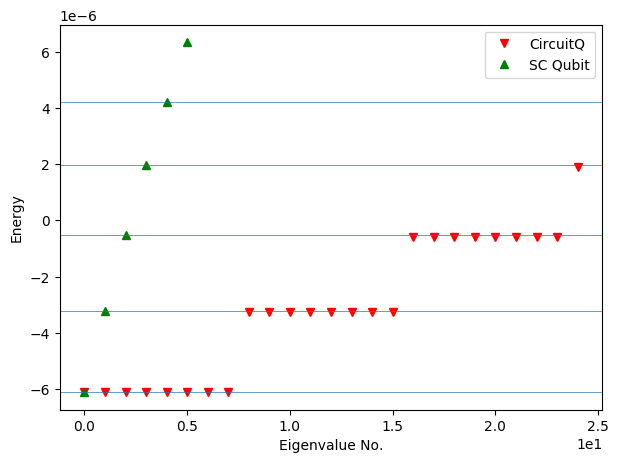

In [11]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(25), eigv[:25], 'rv', label="CircuitQ")
plt.plot(np.arange(6), esys[0][:6], 'g^', label="SC Qubit")
plt.legend()
plt.xlabel("Eigenvalue No.")
plt.ylabel("Energy")
for n in range(5):
    plt.axhline(esys[0][n], lw=0.5)
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.show() 

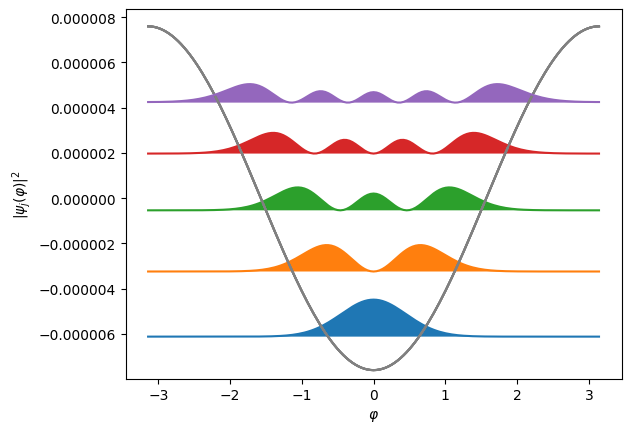

In [12]:
transmon.plot_phi_wavefunction(esys=esys, which=[0,1,2,3,4], mode='abs_sqr');

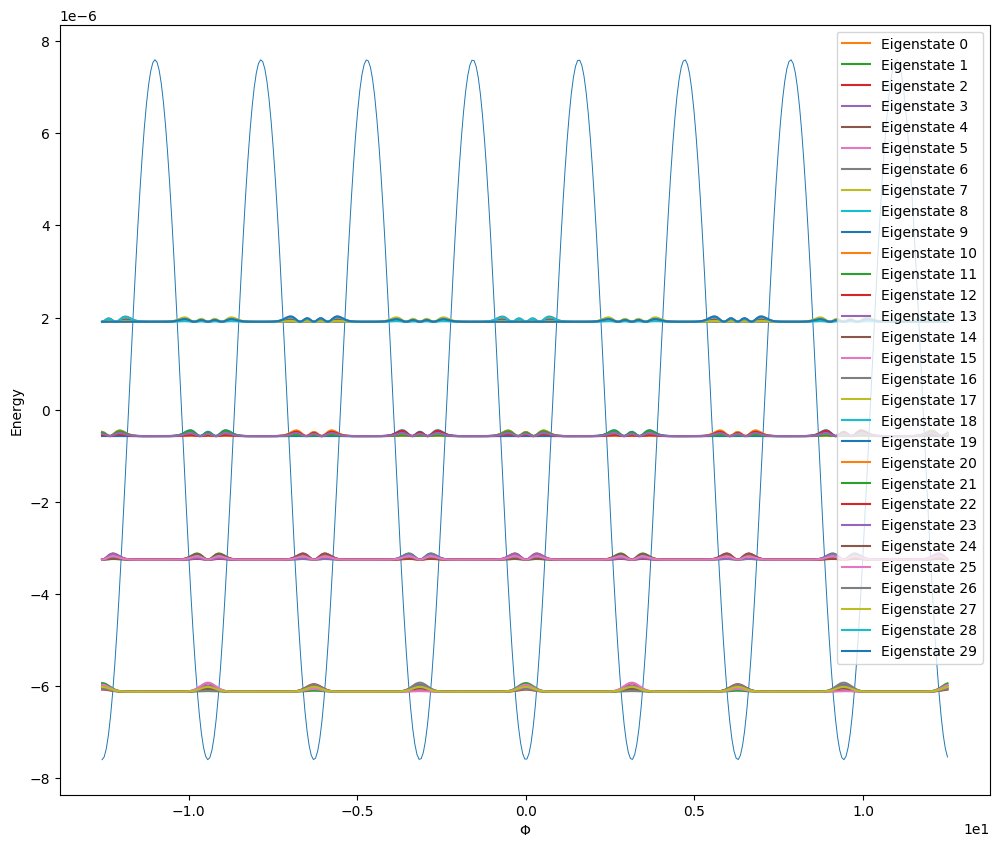

In [13]:
plt.style.use('default')
plt.figure(figsize=(12,10))
def potential(phi):
    return -circuit.c_v["E"]*np.cos(phi/circuit.phi_0)
plt.plot(circuit.coord_list, potential(circuit.coord_list), lw=0.7)
for n in range(30):
    plt.plot(circuit.coord_list, 
             eigv[n] + (abs(eigs[:,n])**2)*circuit.c_v["E"] ,label="Eigenstate " +str(n))
plt.legend()
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.xlabel(r"$\Phi$")
plt.ylabel("Energy")
plt.show()

## Test 2: Fluxonium
### CircuitQ
#### Circuit

In [14]:
graph = nx.MultiGraph()
graph.add_edge(0,1, element = 'C')
graph.add_edge(0,1, element = 'J')
graph.add_edge(0,1, element = 'L');

#### Symbolic Hamiltonian

In [15]:
circuit = cq.CircuitQ(graph)
circuit.h

-E_{J010}*cos(2.0*\Phi_{1}) + (\Phi_{1} + \tilde{\Phi}_{010})**2/(2*L_{010}) + 0.5*q_{1}**2/C_{01}

#### Diagonalization

In [16]:
h_num = circuit.get_numerical_hamiltonian(401)
eigv, eigs = circuit.get_eigensystem()

### SCQubit

In [17]:
EJ = circuit.c_v["E"]
EC = circuit.c_v["E_C"]
EL = (circuit.phi_0**2) / circuit.c_v["L"]
fluxonium = sc.Fluxonium(EJ = EJ, EC = EC, EL = EL, flux = 0, cutoff = 401)
esys = fluxonium.eigensys(evals_count=50)

### Compare

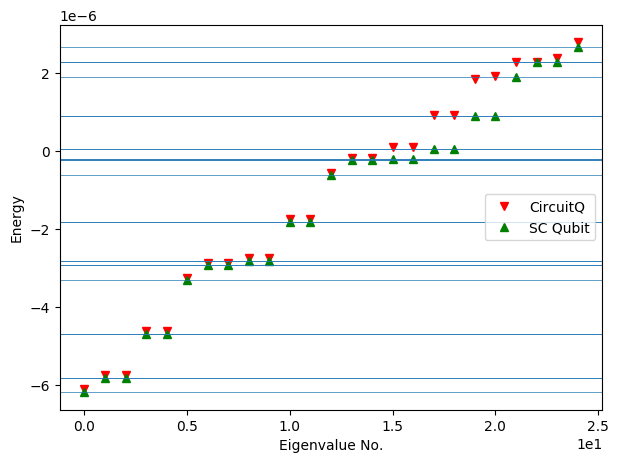

In [18]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(25), eigv[:25], 'rv', label="CircuitQ")
plt.plot(np.arange(25), esys[0][:25], 'g^', label="SC Qubit")
plt.legend()
plt.xlabel("Eigenvalue No.")
plt.ylabel("Energy")
for n in range(25):
    plt.axhline(esys[0][n], lw=0.5)
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.show() 

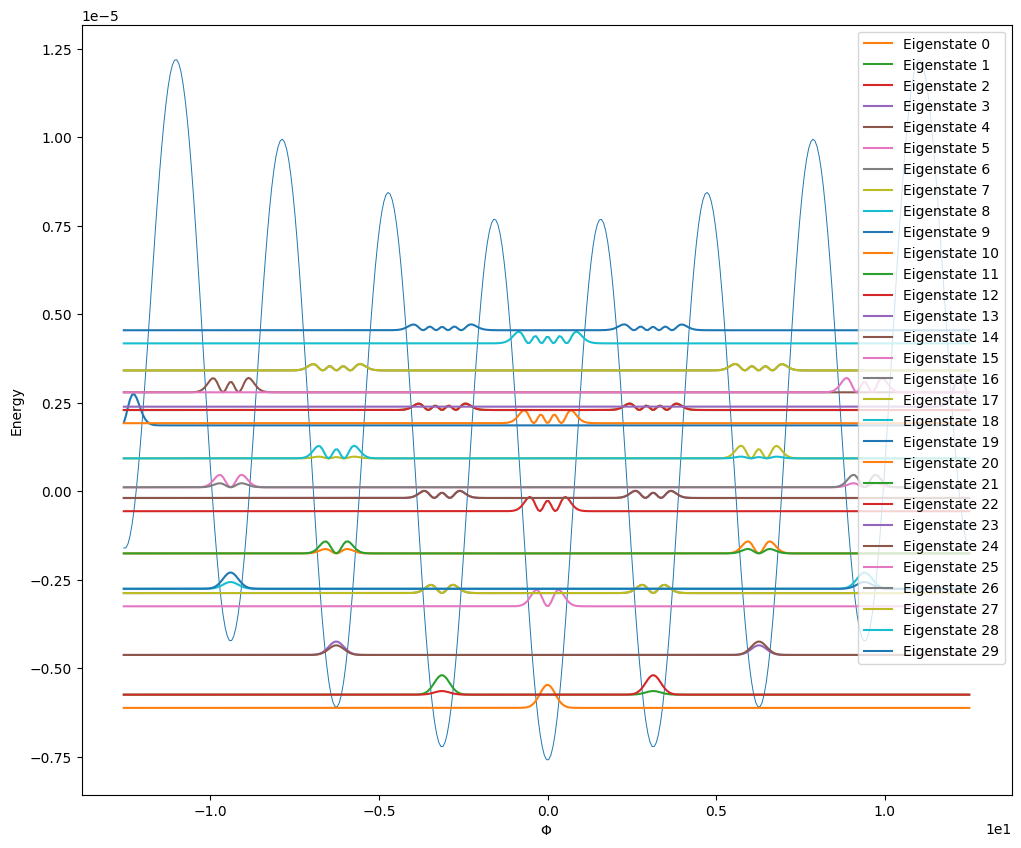

In [19]:
plt.style.use('default')
plt.figure(figsize=(12,10))
def potential(phi):
    return -circuit.c_v["E"]*np.cos(phi/circuit.phi_0) + phi**2/(2*circuit.c_v["L"])
plt.plot(circuit.coord_list, potential(circuit.coord_list), lw=0.7)
for n in range(30):
    plt.plot(circuit.coord_list, 
             eigv[n]+ abs(eigs[:,n])**2*(max(circuit.coord_list)**2/(2*circuit.c_v["L"])) 
             ,label="Eigenstate " +str(n))
plt.legend()
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.xlabel(r"$\Phi$")
plt.ylabel("Energy")
plt.show()

## Test 3: Flux Qubit
### CircuitQ
#### Circuit

In [20]:
graph = nx.MultiGraph()
graph.add_edge(0,1, element = 'C')
graph.add_edge(0,1, element = 'J')
graph.add_edge(1,2, element = 'C')
graph.add_edge(1,2, element = 'J')
graph.add_edge(0,2, element = 'C')
graph.add_edge(0,2, element = 'J');

#### Symbolic Hamiltonian

In [21]:
circuit = cq.CircuitQ(graph)
circuit.h_parameters

[C_{01}, C_{02}, C_{12}, E_{J010}, E_{J020}, E_{J120}, \tilde{\Phi}_{120}]

#### Diagonalization

In [22]:
dim = 130
EJ = circuit.c_v["E"]
alpha = 0.7
C = circuit.c_v["C"]
h_num = circuit.get_numerical_hamiltonian(dim, parameter_values=[C,C,C,EJ,EJ,alpha*EJ,0])
eigv, eigs = circuit.get_eigensystem(200)

In [23]:
subs_dict = dict()
for n, parameter in enumerate(circuit.h_parameters):
    subs_dict[parameter] = circuit.parameter_values[n] 
circuit.h.subs(subs_dict)

0.5*q_{1}*(2.02643979467091e-7*q_{1} + 1.01321989733545e-7*q_{2}) + 0.5*q_{2}*(1.01321989733545e-7*q_{1} + 2.02643979467091e-7*q_{2}) - 7.5991492300159e-6*cos(2.0*\Phi_{1}) - 7.5991492300159e-6*cos(2.0*\Phi_{2}) - 5.31940446101113e-6*cos(2.0*\Phi_{1} - 2.0*\Phi_{2})

### SCQubit

In [24]:
EC = circuit.c_v["E_C"]
fluxqubit = sc.FluxQubit(EJ1 = EJ, EJ2 = EJ, EJ3 = alpha*EJ,
                         ECJ1 = EC, ECJ2 = EC, ECJ3 = EC,
                         ECg1 = 1e20, ECg2 = 1e20, ng1 = 0, ng2 = 0,
                         flux = 0, ncut = int(dim/4))
esys = fluxqubit.eigensys(evals_count=30)

### Compare

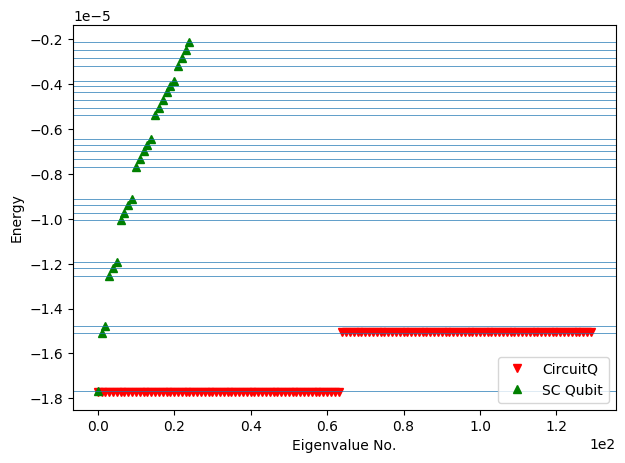

In [25]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(130), eigv[:130], 'rv', label="CircuitQ")
plt.plot(np.arange(25), esys[0][:25], 'g^', label="SC Qubit")
plt.legend()
plt.xlabel("Eigenvalue No.")
plt.ylabel("Energy")
for n in range(25):
    plt.axhline(esys[0][n], lw=0.5)
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.show() 

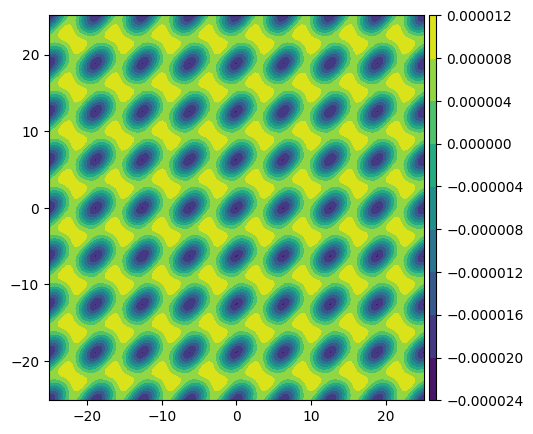

In [26]:
phi_grid = sc.Grid1d(-4*np.pi/circuit.phi_0, 4*np.pi/circuit.phi_0, dim)
fluxqubit.plot_potential(phi_grid=phi_grid);

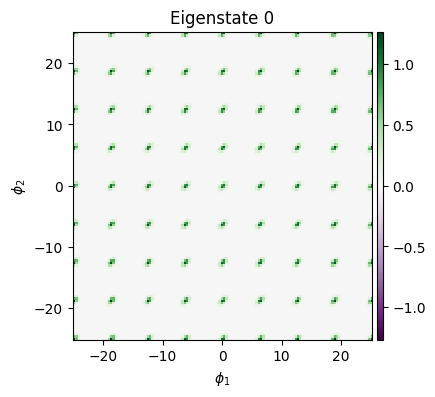

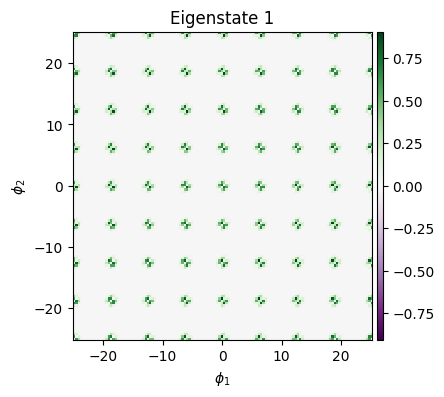

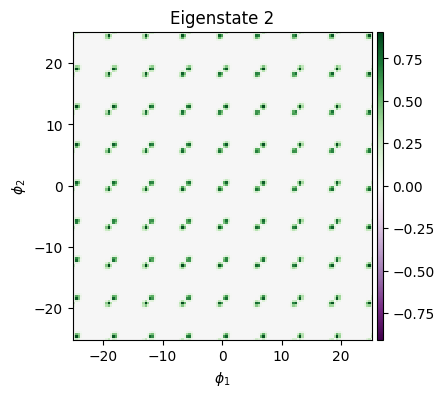

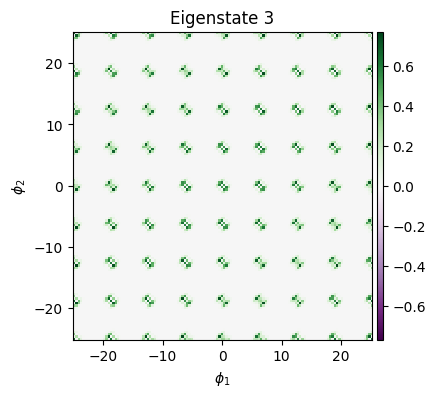

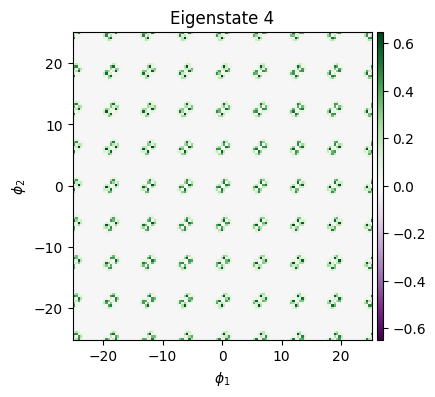

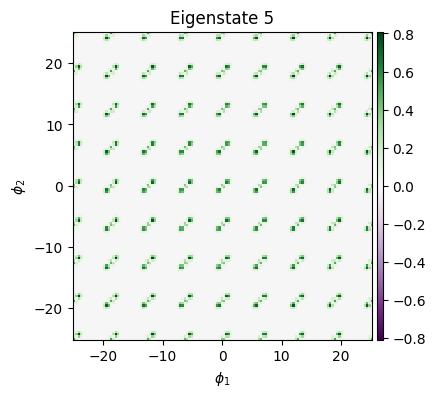

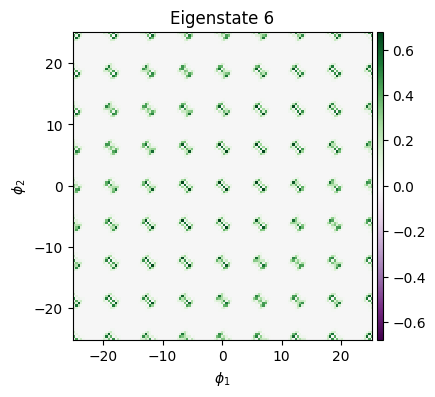

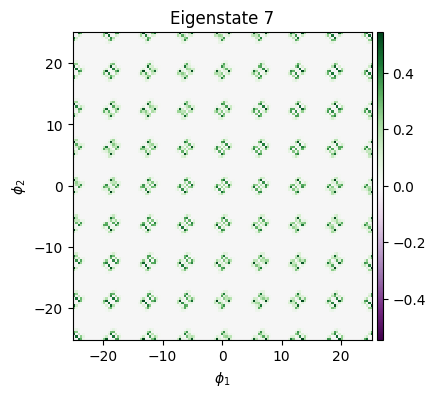

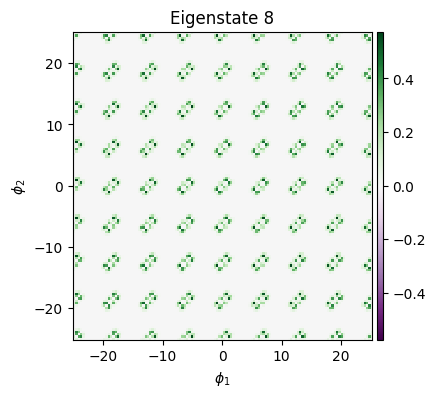

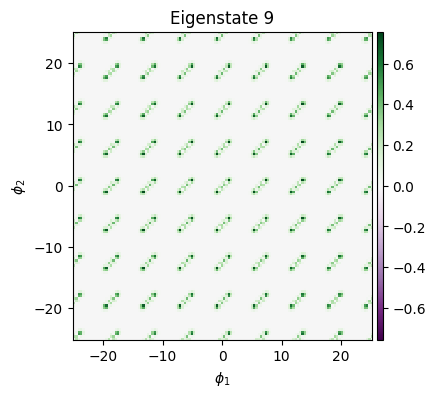

In [27]:
for n in range(10):
    fig, ax = fluxqubit.plot_wavefunction(esys=esys, which=n, phi_grid=phi_grid, mode='abs_sqr',figsize=(4,4));
    ax.set_title("Eigenstate " + str(n))
    ax.set_xlabel(r"$\phi_1$")
    ax.set_ylabel(r"$\phi_2$")
plt.show()

In [28]:
def potential(phi_1, phi_2):
    return (-circuit.c_v["E"]*np.cos(phi_1/circuit.phi_0) - circuit.c_v["E"]*np.cos(phi_2/circuit.phi_0) -
             circuit.c_v["E"]*np.cos((phi_2-phi_1)/circuit.phi_0) )

In [29]:
phis = np.arange(-4*np.pi, 4*np.pi, 8*np.pi/dim)
potential_list = []
for phi_1 in phis:
    for phi_2 in phis:
        potential_list.append(potential(phi_1,phi_2))

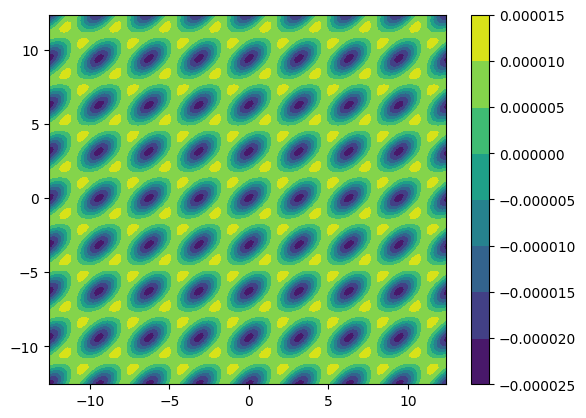

In [30]:
plt.style.use('default')
plt.contourf(phis, phis, np.array(potential_list).reshape(dim,dim))
plt.colorbar()
plt.show()

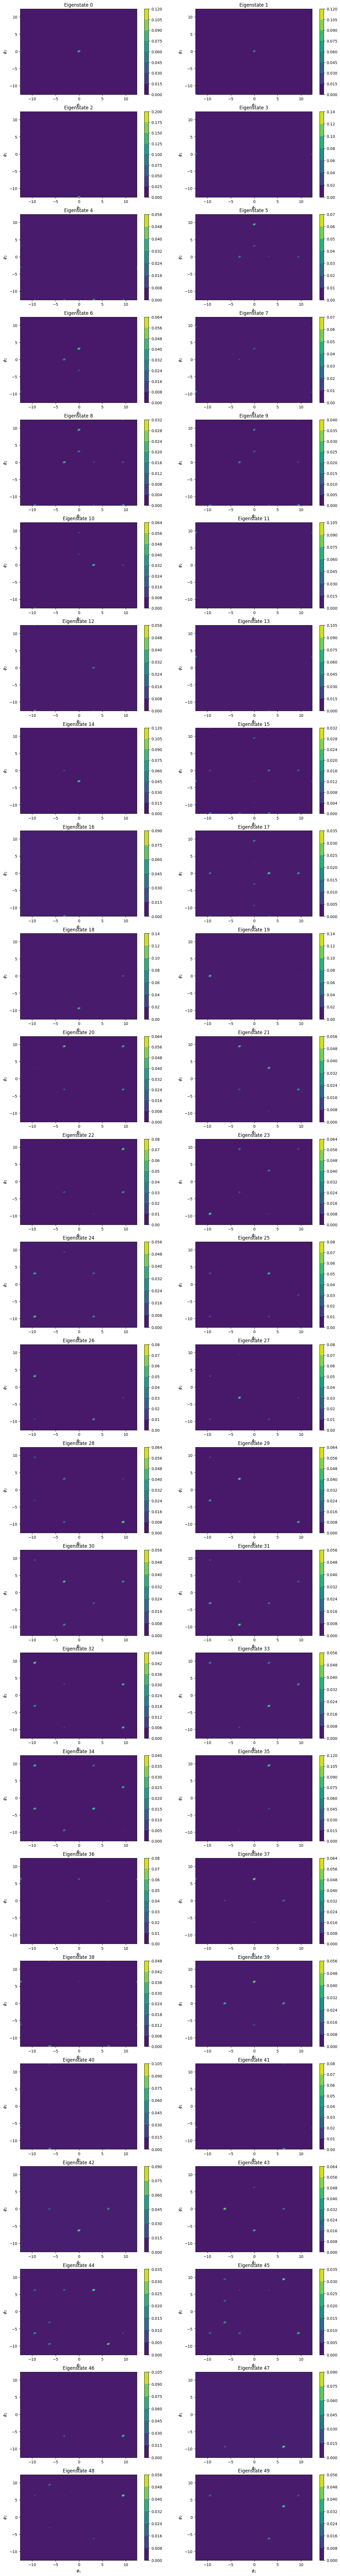

In [31]:
plt.figure(figsize=(15,120))
for n in range(50):
    plt.subplot(25,2, n+1)
    plt.contourf(phis, phis, abs(np.array(eigs[:,n].reshape(dim,dim)))**2)
    plt.colorbar()
    plt.title("Eigenstate " + str(n) )
    plt.xlabel(r"$\phi_1$")
    plt.ylabel(r"$\phi_2$")
plt.show()

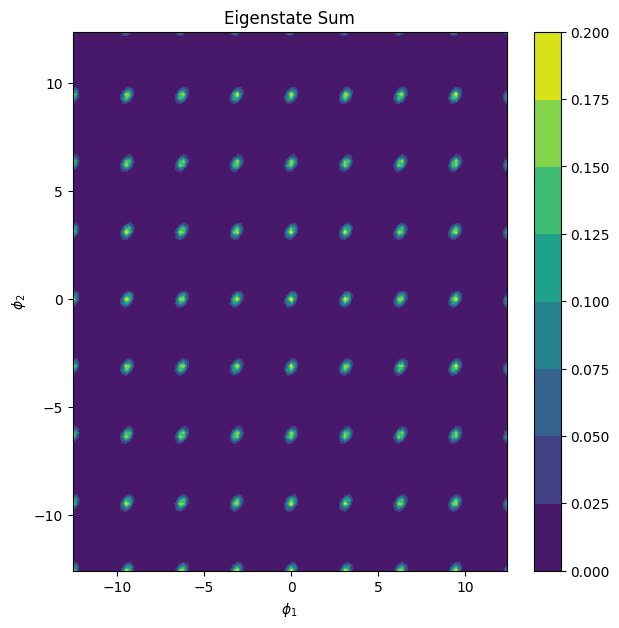

In [32]:
sum_eigs = abs(np.array(eigs[:,0].reshape(dim,dim)))**2
for n in range(1,64):
    sum_eigs += abs(np.array(eigs[:,n].reshape(dim,dim)))**2

plt.figure(figsize=(7,7))
plt.contourf(phis, phis, sum_eigs)
plt.colorbar()
plt.title("Eigenstate Sum")
plt.xlabel(r"$\phi_1$")
plt.ylabel(r"$\phi_2$")
plt.show()